In [1]:
from pathlib import Path

import numpy as np
import scipy.sparse as sp
import torch
from torch.optim import Adam, Optimizer
from tqdm import trange
from torch.utils.data import Dataset, DataLoader
from torch import nn

from src.recommender_model import RecommenderModel
from src.utils import train_model, write_submission, plot_losses, evaluate_model

# Matrix Factorization - BPR
The Bayesian Personalized Ranking loss should be more effective as the dataset uses implicit feedback.

In [2]:
class MFModel(nn.Module):
	def __init__(self, num_users: int, num_items: int, embedding_dim: int, dropout: float, activation = nn.ReLU(), use_linear: bool = False):
		super(MFModel, self).__init__()

		self.num_users = num_users
		self.num_items = num_items
		self.embedding_dim = embedding_dim

		self.users_embeddings = nn.Embedding(num_embeddings=num_users, embedding_dim=embedding_dim)
		self.items_embeddings = nn.Embedding(num_embeddings=num_items, embedding_dim=embedding_dim)

		nn.init.xavier_uniform_(self.users_embeddings.weight, gain=1.0)
		nn.init.xavier_uniform_(self.items_embeddings.weight, gain=1.0)

		self.dropout = nn.Dropout(dropout)

		if use_linear:
			self.fc = nn.Linear(in_features=embedding_dim, out_features=1)
		else:
			self.fc = lambda x: torch.sum(x, dim=-1, keepdim=True)  # for standard scalar product

		self.activation = activation

	def forward(self, users: torch.tensor, items: torch.tensor) -> torch.tensor:
		user_embeddings = self.dropout(self.users_embeddings(users))
		item_embeddings = self.dropout(self.items_embeddings(items))
		return self.activation(self.fc(user_embeddings * item_embeddings))

In [3]:
class URMDatasetNegativeSampling(Dataset):
	"""URM Dataset with negative sampling"""
	def __init__(self, urm: sp.csr_matrix):
		self.urm: sp.csr_matrix = urm
		self.num_items: int = self.urm.shape[1]

		urm_coo = self.urm.tocoo()
		self.user_item_coordinates = torch.from_numpy(
			np.vstack((urm_coo.row, urm_coo.col)).T
		)
		# self.ratings = None  # assume implicit ratings
		self.user_item_sets = {
			user_id: set(
				self.urm.getrow(user_id).indices
			)
			for user_id in range(self.urm.shape[0])
		}  # we use sets to check if an item has been interacted with as it has constant access time

	def __getitem__(self, idx):
		user, pos_sample = self.user_item_coordinates[idx]
		neg_sample = torch.randint(self.num_items, size=())
		while neg_sample in self.user_item_sets[user.item()]:
			neg_sample = torch.randint(self.num_items, size=())
		return user, pos_sample, neg_sample

	def __len__(self):
		return self.urm.nnz

In [4]:
def bpr_loss(pos_scores, neg_scores):
	return -torch.mean(torch.log(torch.sigmoid(pos_scores - neg_scores)))

In [5]:
class MFBPR(RecommenderModel):
	def __init__(self):
		super(MFBPR, self).__init__()
		self.mf_model: MFModel | None = None
		self.optimizer: Optimizer | None = None
		self.loss_fn = None
		self.use_linear: bool = False
		self.best_map = 0.0
		self.checkpoint_dir = Path("model_checkpoints")
		self.checkpoint_dir.mkdir(exist_ok=True)

	def save_checkpoint(self, map_score: float, epoch: int) -> None:
		"""Save model checkpoint if current MAP@10 is better than previous best

		Args:
			map_score: Current MAP@10 score
			epoch: Current epoch number
		"""
		if map_score > self.best_map:
			self.best_map = map_score
			checkpoint = {
				'epoch': epoch,
				'model_state_dict': self.mf_model.state_dict(),
				'optimizer_state_dict': self.optimizer.state_dict(),
				'map_score': map_score,
				'embedding_dim': self.mf_model.embedding_dim,
				'num_users': self.mf_model.num_users,
				'num_items': self.mf_model.num_items,
			}

			checkpoint_path = self.checkpoint_dir / 'best_model.pth'
			torch.save(checkpoint, checkpoint_path)

	def load_best_model(self) -> None:
		"""Load the best performing model"""
		checkpoint_path = self.checkpoint_dir / 'best_model.pth'
		if checkpoint_path.exists():
			checkpoint = torch.load(checkpoint_path)

			# Recreate the model if it doesn't exist
			if self.mf_model is None:
				self.mf_model = MFModel(
					num_users=checkpoint['num_users'],
					num_items=checkpoint['num_items'],
					embedding_dim=checkpoint['embedding_dim'],
					dropout=0.0  # We typically don't need dropout during inference
				)

			self.mf_model.load_state_dict(checkpoint['model_state_dict'])
			if self.optimizer is not None:
				self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

			self.best_map = checkpoint['map_score']
			print(f"Loaded best model with MAP@10: {self.best_map:.5f} from epoch {checkpoint['epoch']}")
		else:
			print("No checkpoint found.")

	def fit(self, urm: sp.csr_matrix, icm: sp.csr_matrix, urm_val: sp.csr_matrix, lr: float = .001, embedding_dim: int = 128, dropout: float = .2, epochs: int = 10, batch_size: int = 8192, weight_decay: float = 1e-6, loss_fn=bpr_loss, activation=nn.ReLU(), use_linear: bool = False, plot_loss: bool = True)-> None:
		self.urm = urm
		self.mf_model = MFModel(urm.shape[0], urm.shape[1], embedding_dim, dropout, use_linear=use_linear)
		self.optimizer = Adam(self.mf_model.parameters(), lr=lr, weight_decay=weight_decay)
		self.loss_fn = loss_fn
		self.use_linear = use_linear

		validation_enabled = urm_val.nnz > 0

		print("Building the datasets...")
		dataloader = DataLoader(
			URMDatasetNegativeSampling(urm),
			batch_size=batch_size,
			shuffle=True,
			num_workers=8,
		)
		dataloader_val = DataLoader(
			URMDatasetNegativeSampling(urm_val),
			batch_size=batch_size,
			num_workers=8,
		)
		dl_len = len(dataloader)

		loss_history_val = np.zeros(epochs + 1)
		map_history = np.zeros(epochs + 1)
		loss_history = np.zeros((dl_len * epochs,))

		if validation_enabled:
			self._compute_full_urm_pred()
			map_history[0], loss_history_val[0] = self._validate(dataloader_val, urm_val)
			self.save_checkpoint(map_history[0], 0)

		print("Training the model...")
		for epoch in (t := trange(epochs)):
			self.mf_model.train()
			for batch_idx, (users, pos_samples, neg_samples) in enumerate(dataloader):
				pos_scores = self.mf_model(
					users,
					pos_samples
				).squeeze()
				neg_scores = self.mf_model(
					users,
					neg_samples
				).squeeze()
				loss = self.loss_fn(pos_scores, neg_scores)

				self.optimizer.zero_grad()
				loss.backward()
				self.optimizer.step()

				loss_history[dl_len * epoch + batch_idx] = loss.item()
				with torch.no_grad():
					t.set_postfix({
						"Batch": f"{(batch_idx + 1) / dl_len * 100:.2f}%",
						"Train loss": f"{loss.item():.5f}",
						"Val loss": f"{loss_history_val[epoch]:.5f}",
						"MAP@10": f"{map_history[epoch]:.5f}",
						"Best MAP@10": f"{self.best_map:.5f}",
						"Pred stats": f"(pos_mean:{pos_scores.mean().item():.4f}, neg_mean:{neg_scores.mean().item():.4f})",
					})
			if validation_enabled:
				self._compute_full_urm_pred()
				map_history[epoch + 1], loss_history_val[epoch + 1] = self._validate(dataloader_val, urm_val)
				self.save_checkpoint(map_history[epoch + 1], epoch + 1)

		if not validation_enabled:
			self._compute_full_urm_pred()  # as it has not been done before

		plot_losses(epochs, loss_history, loss_history_val, len(dataloader), ('MAP@10', [x * len(dataloader) for x in range(epochs + 1)], map_history))

	@torch.no_grad()
	def _compute_full_urm_pred(self) -> None:
		"""In-place computation of the final predicted URM matrix using the final Linear layer"""
		self.mf_model.eval()
		del self.urm_pred  # free memory

		if self.use_linear:
			w = self.mf_model.fc.weight
			w_sign = torch.sign(w)
			w_sqrt = torch.sqrt(torch.abs(w))
			b = self.mf_model.fc.bias.item() or 0

			weighted_users_embeddings = self.mf_model.users_embeddings.weight * w_sqrt * w_sign
			weighted_items_embeddings = self.mf_model.items_embeddings.weight * w_sqrt

			self.urm_pred = self.mf_model.activation(
				weighted_users_embeddings @ weighted_items_embeddings.T + b
			).numpy()
		else:
			self.urm_pred = (
				self.mf_model.users_embeddings.weight @ self.mf_model.items_embeddings.weight.T
			).numpy()

	@torch.no_grad()
	def _validate(self, dataloader_val: DataLoader, urm_val: sp.csr_matrix) -> tuple[float, float]:
		self.mf_model.eval()
		loss = 0
		for users, pos_samples, neg_samples in dataloader_val:
			pos_scores = self.mf_model(
				users,
				pos_samples
			).squeeze()
			neg_scores = self.mf_model(
				users,
				neg_samples
			).squeeze()
			loss += self.loss_fn(pos_scores, neg_scores)

		loss /= len(dataloader_val)
		return evaluate_model(self, urm_val, users_to_test=.2), loss.item()

Building the datasets...
Training the model...


100%|██████████| 25/25 [10:11<00:00, 24.47s/it, Batch=100.00%, Train loss=0.18020, Val loss=0.16761, MAP@10=0.01322, Best MAP@10=0.01407, Pred stats=(pos_mean:7.4543, neg_mean:3.2720)]


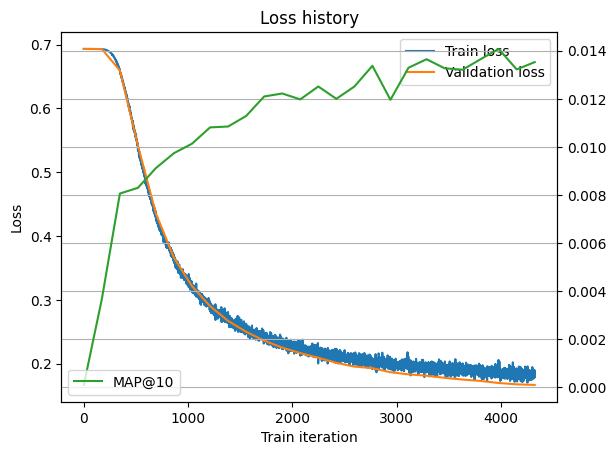

MAP@10 evaluation of the MFBPR model: 0.01455


In [6]:
bpr_train = train_model(MFBPR(), batch_size=8192, epochs=25, embedding_dim=16, weight_decay=0, loss_fn=bpr_loss, activation=nn.ReLU(), use_linear=False)